# KDD 2009 - Tratamento de dados simplista
Como parte do exercício de resolução do KDD Cup de 2009 criamos este notebook para realizar um teste do modelo preditivo sem fazer grandes alterações nos dados originais. A análise completa pode ser vista [aqui](./KDD2009.ipynb).

O objetivo é ter um parâmetro de comparação com o modelo entregue, que utiliza o **vtreat** para gerar um plano de tratamento das variáveis do KDD Cup 2009, para cada uma dos resultados desejados (*appetency*, *churn* e *up-selling*).

Os únicos tratamentos serão:
- Remoção das variáveis nulas (sem nenhum valor válido)
- Conversão das variáveis categóricas para valores numéricos

Os valores NA do conjunto de dados serão mantidos como estão.

In [1]:
dados <- read.table('orange_small_train.data', sep='\t', header=T, na.strings=c(''))

In [2]:
# Leitura dos rótulos dos dados
appetency <- read.table('orange_small_train_appetency.labels', sep='\t', header=F, col.names=c("appetency"))
churn <- read.table('orange_small_train_churn.labels', sep='\t', header=F, col.names=c("churn"))
upselling <- read.table('orange_small_train_upselling.labels', sep='\t', header=F, col.names=c("upselling"))

# Inclusão dos rótulos no conjunto de dados como colunas adicionais
dados$appetency <- appetency$appetency
dados$churn <- churn$churn
dados$upselling <- upselling$upselling

In [3]:
# Inclusão de bibliotecas
library('vtreat')
library('ggplot2')
library('parallel')
library('WVPlots')
library('xgboost')
library('Metrics')

In [4]:
# Colunas de resultado
resultados <- c("appetency", "churn", "upselling")
# Colunas de variaveis
variaveis <- setdiff(colnames(dados), resultados)

# Conversão dos valores dos rótulos
Convertemos os valores originais dos rótulos (*appetency*, *churn* e *upselling*) de -1 (negativo) e 1 (positivo) para FALSE e TRUE, respectivamente.

In [5]:
dados[['appetency']] <- dados[['appetency']]==1
dados[['churn']] <- dados[['churn']]==1
dados[['upselling']] <- dados[['upselling']]==1

In [6]:
head(dados[resultados])

appetency,churn,upselling
FALSE,FALSE,FALSE
FALSE,TRUE,FALSE
FALSE,FALSE,FALSE
FALSE,FALSE,FALSE
FALSE,FALSE,FALSE
FALSE,FALSE,FALSE


In [7]:
variaveisCategoricas <- variaveis[sapply(dados[,variaveis], class) %in% c('factor', 'character')]

In [8]:
variaveisNumericas <- variaveis[sapply(dados[,variaveis], class) %in% c('numeric', 'integer')]

In [9]:
variaveisOutras <- setdiff(variaveis, union(variaveisNumericas, variaveisCategoricas))

In [10]:
summary(dados[variaveisOutras])

   Var8          Var15          Var20          Var31          Var32        
 Mode:logical   Mode:logical   Mode:logical   Mode:logical   Mode:logical  
 NA's:50000     NA's:50000     NA's:50000     NA's:50000     NA's:50000    
  Var39          Var42          Var48          Var52          Var55        
 Mode:logical   Mode:logical   Mode:logical   Mode:logical   Mode:logical  
 NA's:50000     NA's:50000     NA's:50000     NA's:50000     NA's:50000    
  Var79          Var141         Var167         Var169         Var175       
 Mode:logical   Mode:logical   Mode:logical   Mode:logical   Mode:logical  
 NA's:50000     NA's:50000     NA's:50000     NA's:50000     NA's:50000    
  Var185         Var209         Var230       
 Mode:logical   Mode:logical   Mode:logical  
 NA's:50000     NA's:50000     NA's:50000    

# Remoção de variáveis
Remoção das variáveis nulas (sem valor) dos dados. Na prática seria suficiente atualizar a lista de variáveis que serão passadas para o modelo preditivo sem estas variáveis.

In [11]:
remover <- !names(dados) %in% c(variaveisOutras)

In [12]:
dados <- dados[remover]

In [13]:
head(dados)

Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,⋯,Var223,Var224,Var225,Var226,Var227,Var228,Var229,appetency,churn,upselling
NA,NA,NA,NA,NA,1526,7,NA,NA,NA,⋯,jySVZNlOJy,NA,NA,xb3V,RAYp,F2FyR07IdsN7I,NA,FALSE,FALSE,FALSE
NA,NA,NA,NA,NA,525,0,NA,NA,NA,⋯,LM8l689qOp,NA,NA,fKCe,RAYp,F2FyR07IdsN7I,NA,FALSE,TRUE,FALSE
NA,NA,NA,NA,NA,5236,7,NA,NA,NA,⋯,jySVZNlOJy,NA,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,FALSE,FALSE,FALSE
NA,NA,NA,NA,NA,NA,0,NA,NA,NA,⋯,LM8l689qOp,NA,NA,FSa2,RAYp,F2FyR07IdsN7I,NA,FALSE,FALSE,FALSE
NA,NA,NA,NA,NA,1029,7,NA,NA,NA,⋯,LM8l689qOp,NA,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,FALSE,FALSE,FALSE
NA,NA,NA,NA,NA,658,7,NA,NA,NA,⋯,LM8l689qOp,NA,NA,Qcbd,02N6s8f,Zy3gnGM,am7c,FALSE,FALSE,FALSE


# Conversão de variáveis categóricas para numéricas
Para poder utilizar os dados no **XGBoost** é necessário converter as variáveis categóricas para numéricas. Este passo não é necessário explicitamente com o **vtreat**.

In [14]:
for (variavel in variaveisCategoricas) {
    dados[variavel] <- as.numeric(dados[,variavel])
} 

In [15]:
head(dados)

Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,⋯,Var223,Var224,Var225,Var226,Var227,Var228,Var229,appetency,churn,upselling
NA,NA,NA,NA,NA,1526,7,NA,NA,NA,⋯,2,NA,NA,23,5,14,NA,FALSE,FALSE,FALSE
NA,NA,NA,NA,NA,525,0,NA,NA,NA,⋯,3,NA,NA,8,5,14,NA,FALSE,TRUE,FALSE
NA,NA,NA,NA,NA,5236,7,NA,NA,NA,⋯,2,NA,2,14,1,15,1,FALSE,FALSE,FALSE
NA,NA,NA,NA,NA,NA,0,NA,NA,NA,⋯,3,NA,NA,9,5,14,NA,FALSE,FALSE,FALSE
NA,NA,NA,NA,NA,1029,7,NA,NA,NA,⋯,3,NA,2,9,5,14,2,FALSE,FALSE,FALSE
NA,NA,NA,NA,NA,658,7,NA,NA,NA,⋯,3,NA,NA,13,1,30,1,FALSE,FALSE,FALSE


In [16]:
tail(dados)

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,⋯,Var223,Var224,Var225,Var226,Var227,Var228,Var229,appetency,churn,upselling
49995,NA,NA,NA,NA,NA,266,0,NA,NA,NA,⋯,3,NA,NA,23,5,14,NA,FALSE,FALSE,FALSE
49996,NA,NA,NA,NA,NA,357,0,NA,NA,NA,⋯,3,NA,NA,5,5,14,NA,TRUE,FALSE,FALSE
49997,NA,NA,NA,NA,NA,1078,0,NA,NA,NA,⋯,3,NA,2,9,5,5,1,TRUE,FALSE,FALSE
49998,NA,NA,NA,NA,NA,2807,7,NA,NA,NA,⋯,3,NA,1,8,5,24,NA,FALSE,FALSE,FALSE
49999,NA,NA,NA,0,NA,NA,NA,NA,NA,NA,⋯,3,NA,NA,9,5,14,NA,FALSE,FALSE,FALSE
50000,NA,NA,NA,NA,NA,1694,7,NA,NA,NA,⋯,3,NA,NA,23,5,14,NA,FALSE,FALSE,TRUE


In [17]:
summary(dados)

      Var1             Var2            Var3               Var4      
 Min.   :  0.00   Min.   :0       Min.   :     0.0   Min.   : 0.00  
 1st Qu.:  0.00   1st Qu.:0       1st Qu.:     0.0   1st Qu.: 0.00  
 Median :  0.00   Median :0       Median :     0.0   Median : 0.00  
 Mean   : 11.49   Mean   :0       Mean   :   425.3   Mean   : 0.13  
 3rd Qu.: 16.00   3rd Qu.:0       3rd Qu.:     0.0   3rd Qu.: 0.00  
 Max.   :680.00   Max.   :5       Max.   :130668.0   Max.   :27.00  
 NA's   :49298    NA's   :48759   NA's   :48760      NA's   :48421  
      Var5              Var6             Var7              Var9        
 Min.   :      0   Min.   :     0   Min.   :  0.000   Min.   :   0.00  
 1st Qu.:      0   1st Qu.:   518   1st Qu.:  0.000   1st Qu.:   4.00  
 Median :      0   Median :   861   Median :  7.000   Median :  20.00  
 Mean   : 238793   Mean   :  1326   Mean   :  6.809   Mean   :  48.15  
 3rd Qu.: 118742   3rd Qu.:  1428   3rd Qu.:  7.000   3rd Qu.:  46.00  
 Max.   :6048550

# Atualizando a lista de variáveis
Como removemos as variáveis vazias do modelo é necessário atualizar a lista de variáveis válidas.

In [18]:
variaveis <- setdiff(colnames(dados), resultados)

# Divisão do conjunto de dados em treinamento e validação
Os dados originais serão divididos em dois conjunto:

- Treinamento, com 90% dos dados (45.000 dados)
- Validação, com 10% dos dados (5.000 dados)

A divisão será feita da mesma forma (com o mesmo seed) que os dados do modelo com tratamento por **vtreat**.

In [19]:
# Número total de pontos de dados
numeroDados <- nrow(dados)

# Fixa semente para reproduzir resultados
set.seed(42)

# Define treino como 90% dos dados de treino e
# validação como os 10% restantes
tamanhoTreino <- floor(0.90 * numeroDados)

# Gera uma amostra aleatória com 90% dos índices
indicesTreino <- sample(seq_len(numeroDados), size = tamanhoTreino)

# Divide os dados nos dois subgrupos
# -indicesTreino são os 10% dos índices restantes
dadosTreino <- dados[indicesTreino, ]
dadosValidacao <- dados[-indicesTreino, ]

# Dimensões dos dados de treino e validação
dim(dadosTreino)
dim(dadosValidacao)

[1] 45000   215

[1] 5000  215

# Parâmetros
Mantemos os parâmetros do **GXBoost** iguais ao modelo completo. A variável a tratar será *churn*.

In [20]:
# Parâmetros do XGBoost
params <- list(booster = "gbtree", objective = "binary:logistic",
               eta=0.05, gamma=0, max_depth=6, min_child_weight=1,
               subsample=1, colsample_bytree=1)
resultado <- 'churn'
rodadas <- 100
xgbDados <- xgb.DMatrix(as.matrix(dadosTreino[variaveis]), label=dadosTreino[, resultado])

In [21]:
modelo <- xgboost(data=xgbDados,
                  params=params,
                  verbose=0,
                  nrounds=rodadas)

In [22]:
validacaoT <- dadosValidacao[resultado]
head(validacaoT)

,churn
23,FALSE
37,FALSE
40,TRUE
48,FALSE
84,FALSE
93,FALSE


In [23]:
validacaoT[['previsao']] <- as.numeric(predict(modelo, as.matrix(dadosValidacao[variaveis])))

In [24]:
aucValidacao = auc(ifelse(validacaoT[, resultado] == TRUE, 1, 0), validacaoT['previsao'])

In [25]:
print(sprintf("AUC Validação (%d): %5.4f", rodadas, aucValidacao))

[1] "AUC Validação (100): 0.7292"


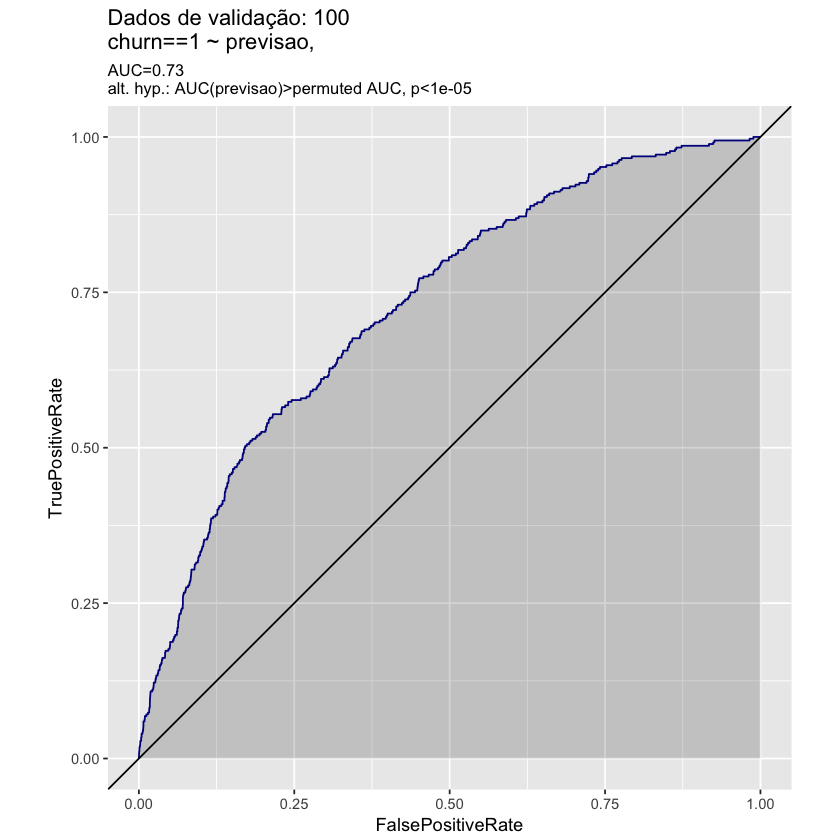

In [26]:
print(ROCPlot(validacaoT, 'previsao', resultado, 1, title=paste('Dados de validação:', rodadas)))

In [27]:
ggsave("baselineChurn.png", plot=last_plot(), device="png", scale=1)

Saving 7 x 7 in image


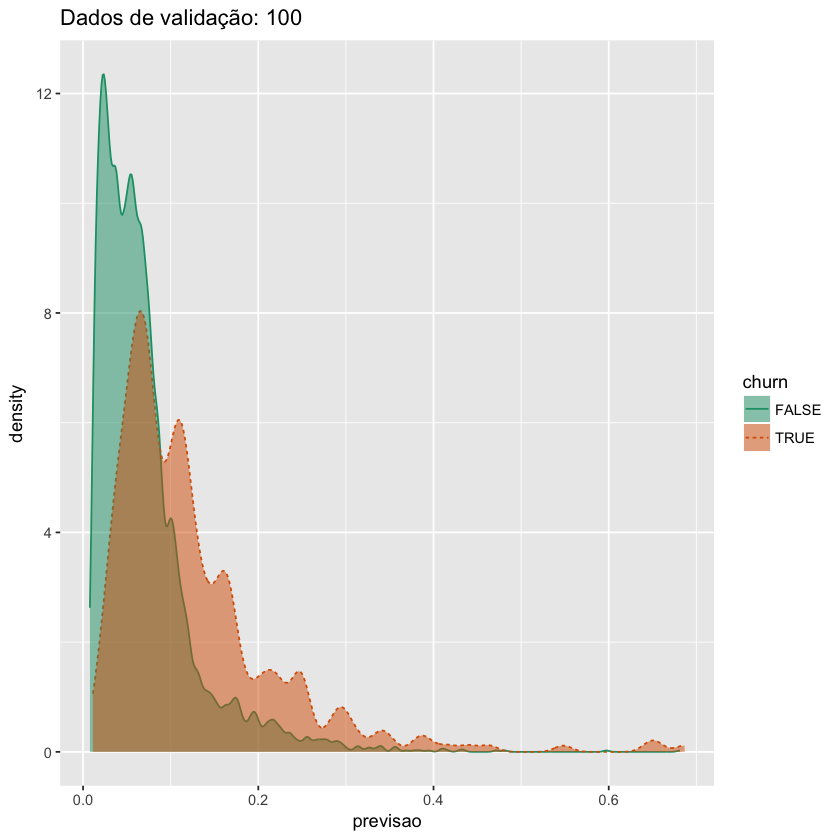

In [28]:
print(DoubleDensityPlot(validacaoT, 'previsao', resultado, title=paste('Dados de validação:', rodadas)))

In [29]:
ggsave("baselineDDChurn.png", plot=last_plot(), device="png", scale=1)

Saving 7 x 7 in image
